# Sequential Minimal Optimization
### A Fast Algorithm for Training Support Vector Machines

Implementing the [Sequential Minimal Optimization (SMO) algorithm](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf) designed by J. C. Platt.


In [1]:
import numpy as np
from sklearn import datasets
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

tol = 0.01
eps = 0.01

## Part 1 - Implementing
This class is used as a cache: for the parameters that will be optimized and also for the hyperparameters.

In [2]:
class SMOModel:
    def __init__(self,X,Y,C,b,kernel):
        self.m = Y.shape[0]
        self.y = Y
        self.X = X
        self.C = C
        self.b = b
        self.kernel = kernel
        self.alphas = np.zeros(self.m)
        self.errors = decision_function(self.alphas, self.y, self.kernel,self.X, self.X, self.b) - self.y

Here we define some functions that will accompany us later:
* __Gaussian kernel:__ $e^{−γ||x'' - x'||^2} $
* __Linear kernel:__  $\langle\,x',x''\rangle$
* __Objective function:__ $-\frac{1}{2}\sum_{n=1}^{N}\\sum_{m=1}^{N} a_n a_m y_n y_m K(x_n , x_m)\ + \sum_{n=1}^{N} a_n\$

* __Decision function:__ $\sum_{i}^{N} a_i y_i K(x_i , x) \ - b$

In [3]:
def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

def linear_kernel(X1,X2):
    return np.inner(X1,X2)

def objective_function(alphas, y, kernel, X):
    return np.sum(alphas) - 0.5 * np.sum((y[:, None] * y[None, :]) * kernel(X, X) * (alphas[:, None] * alphas[None, :]))

def decision_function(alphas, y, kernel, X_train, x_test, b):
    result = (alphas * y) @ kernel(X_train, x_test) - b
    return result

This function updates the lagrange multipliers and the errors of the data in the index i1 and i2 and also the b.

In [4]:
def takeStep(i1, i2, model):
    
    if i1 == i2: #If the alphas are the same - skip
        return 0, model
    
    # Extraction of the variables from the cache
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    
    s = y1*y2
    
    #Calculate the upper and lower boundary (depending on the value of the labels y1 & y2)
    if y1 == y2:
        L = max(0 , alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    else:
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
     
    #Skip if the lower and the upper bounds are the same
    if L == H:
        return 0, model
    
    #Compute the differnet kernels
    k11 = model.kernel(model.X[i1],model.X[i1])
    k12 = model.kernel(model.X[i1],model.X[i2])
    k22 = model.kernel(model.X[i2],model.X[i2])
    
    #Compute eta
    eta = k11 + k22 - 2*k12
    
    #If eta is positive - compute a2 as function of the old a2, the errors, the label and eta.
    #(This solution can be reached analytically without the need for complicated optimization,
    #which is the advantage of the SMO algorithm)
    if eta > 0:
        a2 = alph2 + (y2*(E1 -E2))/eta
        
        #Clip a2 by the bounds L and H
        if a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H
    else:
        #Here we make copy because we don't want to chahge the original alphas values, we just wanna to compute the
        #different objective functions for a2.
        alphas_adj = model.alphas.copy()
        
        alphas_adj[i2] = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) # Objective function at a2=L
        
        alphas_adj[i2] = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X) # Objective function at a2=H
        
        #Clip a2 at the same way as mentioned in the article
        if Lobj < (Hobj - eps):
            a2 = L
        elif Lobj > (Hobj + eps):
            a2 = H
        else:
            a2 = alph2
    
    #If a2 value is very small - enter a value of 0        
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    #Skip this step if the change in a2 is less than *eps(a2_new + a2_old + eps)       
    if abs(a2 - alph2) < eps*(a2+alph2+eps):
        return 0, model
    
    #Compute a1 as a function of the old a1, a2 and s.
    #(This solution can be reached analytically without the need for complicated optimization,
    #which is the advantage of the SMO algorithm)
    a1 = alph1 + s*(alph2 - a2)
      
    # Update value of the threshold b by the new a1 & a2, Compute both possible values for the new treshold.
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
     
    #Update the threshold according to the a that does not violate the conditions, 
    #if both don't violate the conditions than new_b = average of a1 and a2 
    if 0 < a1 and a1 < model.C:
        b = b1
    elif 0 < a2 and a2 < model.C:
        b = b2
    else:
        b = (b1 + b2) * 0.5
    
    #Push the new alphas values to cache
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    #Update error cache to 0 if a1 ,a2 are in the bounds range
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph and alph < model.C:
            model.errors[index] = 0.0
     
    
    #Update error cache of the other alpahs
    NonOpt = list(filter(lambda n: n != i1 and n != i2, list(range(model.m))))
    
    model.errors[NonOpt] = model.errors[NonOpt] + y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[NonOpt]) +y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[NonOpt]) + model.b - b
    
    #Update b
    model.b = b
    
    return 1, model

In this function we will use the heuristic method to select the i1 according to i2, then we will take a step.

In [5]:
def examineExample(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2*y2
    
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        #if (number of non-zero & non-C alpha > 1)
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            
            #This is the heuristic method I found online
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors) 
                
            step, model = takeStep(i1, i2, model)
            
            if step:
                return 1, model
         
        #loop over all non-zero and non-C alpha, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0], np.random.choice(np.arange(model.m))):
            step, model = takeStep(i1, i2, model)
            if step:
                return 1, model
        
        #loop over all possible i1, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step, model = takeStep(i1, i2, model)
            if step:
                return 1, model
            
    return 0, model

This is the function that combines everything together - the function gets model cache and returns a trained model (I.e. new alphas and b values according to the data).

In [6]:
def train(model):
    numChanged = 0
    examineAll = 1

    while numChanged > 0 or examineAll:
        numChanged = 0
        if examineAll:
            for i in range(model.m):
                res , model = examineExample(i, model)
                numChanged += res
                
        else:
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                res , model = examineExample(i, model)
                numChanged += res
                
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
    return model

## Part 2 - training & testing
Training and esting the model on the famous dataset __'Iris'__.

In [7]:
iris = datasets.load_iris()

#Convert to data frame
df = pd.DataFrame(iris.data)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df['class'] = iris.target

df.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,class
91,6.1,3.0,4.6,1.4,1
18,5.7,3.8,1.7,0.3,0
143,6.8,3.2,5.9,2.3,2
78,6.0,2.9,4.5,1.5,1
103,6.3,2.9,5.6,1.8,2
60,5.0,2.0,3.5,1.0,1
107,7.3,2.9,6.3,1.8,2
135,7.7,3.0,6.1,2.3,2
83,6.0,2.7,5.1,1.6,1
56,6.3,3.3,4.7,1.6,1


Now according to the following plot we can get an intuition about the degree of linear separation of the data.

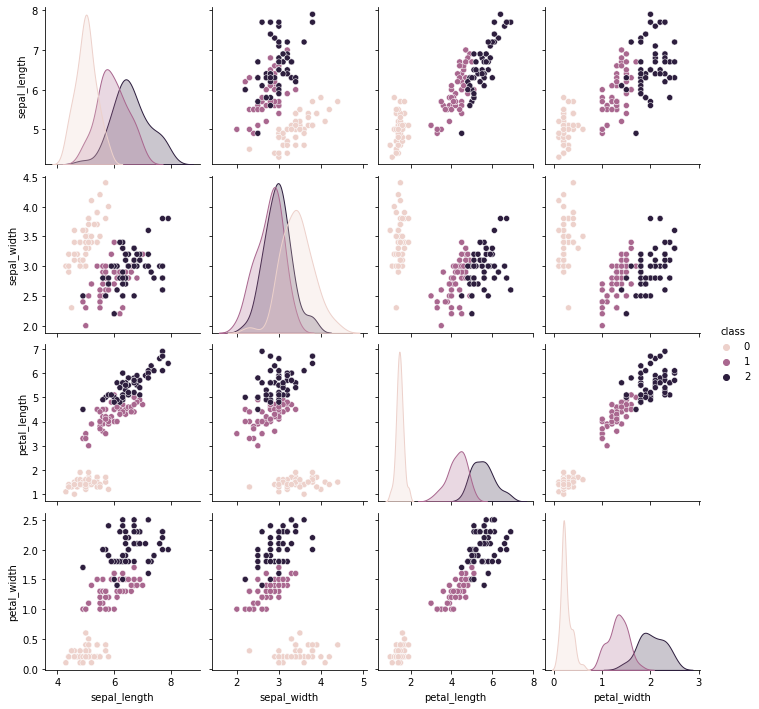

In [8]:
sns.pairplot(df, hue='class')  
plt.show()

It can be clearly seen that flowers in class 0 can be linearly separated from other types in flowers. <br/><br/>
Now for the *one vs all* method we need to train the model for data tagged as belonging to class i (+1) and data not associated with this class (-1).<br/> When i = 0,1,2.

In [9]:
def isClass(x ,Class):
    if Class == x:
        return 1
    return -1

df['0'] = df['class'].apply(lambda x: isClass(x,0))
df['1'] = df['class'].apply(lambda x: isClass(x,1))
df['2'] = df['class'].apply(lambda x: isClass(x,2))

df.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,class,0,1,2
44,5.1,3.8,1.9,0.4,0,1,-1,-1
135,7.7,3.0,6.1,2.3,2,-1,-1,1
79,5.7,2.6,3.5,1.0,1,-1,1,-1
0,5.1,3.5,1.4,0.2,0,1,-1,-1
61,5.9,3.0,4.2,1.5,1,-1,1,-1
126,6.2,2.8,4.8,1.8,2,-1,-1,1
124,6.7,3.3,5.7,2.1,2,-1,-1,1
40,5.0,3.5,1.3,0.3,0,1,-1,-1
146,6.3,2.5,5.0,1.9,2,-1,-1,1
141,6.9,3.1,5.1,2.3,2,-1,-1,1


This function trains the model according to class i and returns the train, test and the validation data plus the trained model.

In [10]:
def train_model(C,b,Class,kernel = linear_kernel):
    
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-4], df[Class], test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    X_train, X_val, X_test, y_train, y_test, y_val = X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy(), y_val.to_numpy() 
    
    model = SMOModel(X_train, y_train, C, b, kernel)
    
    np.random.seed(0)
    model = train(model)
    
    return X_train, X_val, X_test, y_train, y_test, y_val, model

In [11]:
# The purpose of this function is to predict whether X_test belongs to class i or not 
#(i is determined by the model that the function receives).

def predict(model,X_test):
    result = np.zeros(X_test.shape[0])
    for i,test in enumerate(X_test):
        result[i] = decision_function(model.alphas, model.y, model.kernel, model.X, test, model.b)
        if result[i] > 0:
            result[i] = 1
        else:
            result[i] = -1
    return result

# The purpose of this function is to check which class the X_test belongs to

def Classifier(model0, model1, model2, X_test):
    result = np.zeros(X_test.shape[0])
    for i,test in enumerate(X_test):
        result[i] = np.argmax(np.array([
            predict(model0,np.array([test]))[0],
            predict(model1,np.array([test]))[0]+0.0001,
            predict(model2,np.array([test]))[0]+0.0001
        ]))
    return result

# This function plot confusion matrix and also prints the accuracy and the sensitivity (if necessary)

def plot_confusion_matrix(y_true,y_pred,title,color='Blues',sensitivity = False):
    cf_matrix = confusion_matrix(y_true,y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap=color)
    ax.set_title(title)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    accuracy = (np.sum(y_true == y_pred)/len(y_true))*100
    print("Accuracy: %.2f%%\n" % accuracy)
    if sensitivity:
        tn, fp, fn, tp = cf_matrix.ravel()
        sensitivity = 100*tp / (tp+fn)
        print("Sensitivity: %.2f%%\n" % sensitivity)

In [12]:
X_train0, X_val0, X_test0, y_train0, y_test0, y_val0, model0 = train_model(C = 1000.0, b = 0.0, Class = '0',kernel = linear_kernel) 
X_train1, X_val1, X_test1, y_train1, y_test1, y_val1, model1 = train_model(C = 15.0, b = 0.0, Class = '1',kernel = linear_kernel)
X_train2, X_val2, X_test2, y_train2, y_test2, y_val2, model2 = train_model(C = 10.0, b = 0.0, Class = '2',kernel = linear_kernel) 

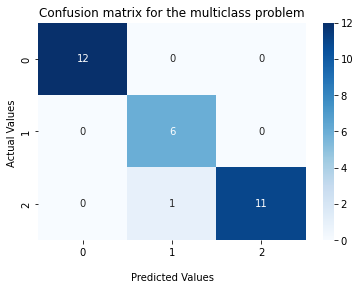

Accuracy: 96.67%



In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-4], df['class'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train, X_val, X_test, y_train, y_test, y_val = X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy(), y_val.to_numpy() 

plot_confusion_matrix(y_val,Classifier(model0,model1,model2,X_val),"Confusion matrix for the multiclass problem","Blues")

Not bad results at all, except for data that can be very confusing most of the data can be identified by our trained model.

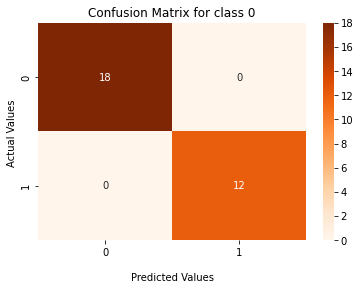

Accuracy: 100.00%

Sensitivity: 100.00%



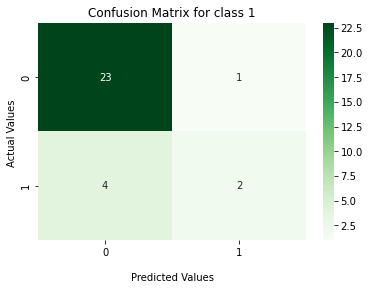

Accuracy: 83.33%

Sensitivity: 33.33%



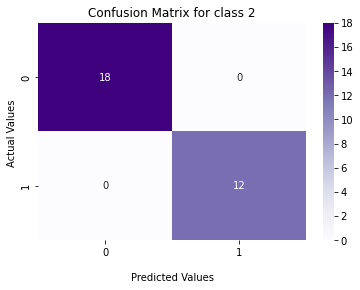

Accuracy: 100.00%

Sensitivity: 100.00%



In [14]:
plot_confusion_matrix(y_val0,predict(model0,X_val0),'Confusion Matrix for class 0','Oranges',True)
plot_confusion_matrix(y_val1,predict(model1,X_val1),'Confusion Matrix for class 1','Greens',True)
plot_confusion_matrix(y_val2,predict(model2,X_val2),'Confusion Matrix for class 2','Purples',True)

For class 0 and class 2 the model is able to detect with high accuracy, for class 1 there is also good accuracy, but it seems that for the model is easier to tell which data does not belong to class 1, which is quite predictable given the plot of the data we saw at the beginning.

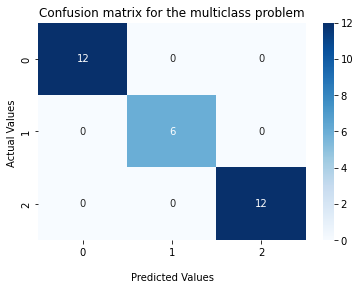

Accuracy: 100.00%



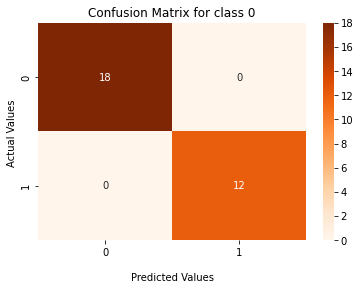

Accuracy: 100.00%

Sensitivity: 100.00%



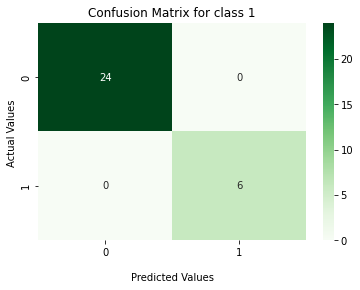

Accuracy: 100.00%

Sensitivity: 100.00%



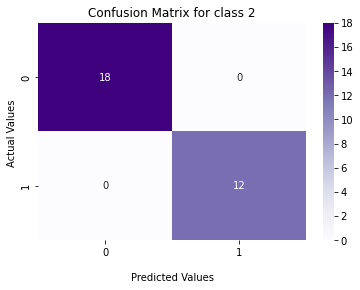

Accuracy: 100.00%

Sensitivity: 100.00%



In [15]:
X_train0, X_val0, X_test0, y_train0, y_test0, y_val0, model0 = train_model(C = 1000.0, b = 0.0, Class = '0',kernel = gaussian_kernel) 
X_train1, X_val1, X_test1, y_train1, y_test1, y_val1, model1 = train_model(C = 15.0, b = 0.0, Class = '1',kernel = gaussian_kernel)
X_train2, X_val2, X_test2, y_train2, y_test2, y_val2, model2 = train_model(C = 15.0, b = 0.0, Class = '2',kernel = gaussian_kernel)

plot_confusion_matrix(y_val,Classifier(model0,model1,model2,X_val),"Confusion matrix for the multiclass problem","Blues")

plot_confusion_matrix(y_val0,predict(model0,X_val0),'Confusion Matrix for class 0','Oranges',True)
plot_confusion_matrix(y_val1,predict(model1,X_val1),'Confusion Matrix for class 1','Greens',True)
plot_confusion_matrix(y_val2,predict(model2,X_val2),'Confusion Matrix for class 2','Purples',True)

The Gaussian kernel seems to be doing what the linear kernel has had a hard time doing, and that is to separate the data well for class 1 as well.
<br/><br/>
## What next?
Once we have decided on the appropriate model with the appropriate parameters, it remains only to check that there are no abnormal results on the test data then we will train the model on all the data and perform assimilation.

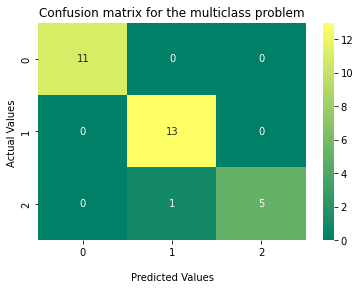

Accuracy: 96.67%



In [20]:
plot_confusion_matrix(y_test,Classifier(model0,model1,model2,X_test),"Confusion matrix for the multiclass problem","summer")